# Web Scrapping Code 1.1

In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
import chromedriver_autoinstaller
import os
import time

# Auto-install Chrome driver
chromedriver_autoinstaller.install()

# Helper function to remove a specific substring
def removeChar(s, x):
    return s.replace(x, "")

# User input for the car they want to buy
user = input("Enter the name of the Car You want to buy: ")

# Prepare the search query by replacing spaces with "+"
st = "+".join(user.split())

# Initialize the Chrome driver once (outside the loop)
driver = webdriver.Chrome()

# Initialize variables
page = 1
total_count = 0

while True:
    url = f'https://www.pakwheels.com/used-cars/search/-/?page={page}&q={st}'
    print("Link:", url, "\n")

    # Open the page in the browser
    driver.get(url)
    time.sleep(2)  # Adding a small delay for the page to fully load

    # Parse the page content
    html = driver.page_source
    parsed_html = BeautifulSoup(html, "html.parser")

    # Scrape car listings
    containers = parsed_html.find_all("div", {"class": "col-md-9 grid-style"})

    if not containers:
        print("No more results, ending scraping.")
        break

    count = 0
    name, city, info1, info2, info3, info4, info5, price, certified, managed_by = [], [], [], [], [], [], [], [], [], []

    for container in containers:
        count += 1
        car_name = container.find('h3').text
        car_name = removeChar(car_name, " for Sale")
        name.append(car_name)

        city_name = container.find('ul', class_='list-unstyled search-vehicle-info fs13').text
        city_name = re.sub(r'[^a-zA-Z]', '', city_name)
        city.append(city_name)

        # Fetch car details (year, KMs, fuel type, etc.)
        info_car = container.find('ul', class_='list-unstyled search-vehicle-info-2 fs13').text.split()
        info1.append(int(info_car[0]))  # year
        info2.append(info_car[1] + info_car[2])  # KMs
        info3.append(info_car[3])  # fuel
        info4.append(info_car[4] + info_car[5])  # horsepower
        info5.append(info_car[6])  # transmission

        # Fetch car price
        prices = container.find('div', class_='price-details generic-dark-grey').text
        prices = re.sub(r'\s+', ' ', prices.strip())
        price.append(prices)

        # Certified or not
        cert = container.find(class_='pull-left mr5')
        certified.append("Certified" if cert else "Not Certified")

        # Managed by PakWheels or Customer
        manage = container.find('span', class_='sold-by-pw')
        managed_by.append("PakWheels" if manage else "Customer")

    # Convert price from text to numbers
    price_number = []
    for price_num in price:
        check = price_num.find('PKR')
        if check == -1:
            price_number.append(0)
        else:
            price_num = price_num.replace('PKR', '')
            number, unit = price_num.split()
            number = float(number)

            if unit == 'lacs':
                number *= 100000
            elif unit == 'crore':
                number *= 10000000

            price_number.append(int(number))

    # Create a DataFrame for this page
    df = pd.DataFrame(list(zip(name, price, price_number, city, info1, info2, info3, info4, info5, certified, managed_by)),
                      columns=['Name', 'PriceInText', 'Price', 'City', 'Year', 'Distance', 'Fuel', 'HorsePower', 'Transmission', 'Certified', 'ManagedBy'])
    df['Distance2'] = df['Distance'].str.replace(',', '').str.replace('km', '')
    df['Distance2'] = pd.to_numeric(df['Distance2'])

    # Check if Excel file exists, if so, append data; otherwise create a new file
    if os.path.exists("Results.xlsx"):
        data2 = pd.read_excel("Results.xlsx")
        data1 = pd.concat([df, data2], ignore_index=True)
        data1 = data1[data1["HorsePower"].str.contains("0.0kWh") == False]
        data1 = data1[data1["PriceInText"].str.contains("Call") == False]
        data1.drop_duplicates(inplace=True)
        data1['Fuel'] = data1['Fuel'].replace('CNG', 'Petrol')
        data1.to_excel("Results.xlsx", index=False, sheet_name='Used Cars')
    else:
        df.to_excel("Results.xlsx", index=False, sheet_name='Used Cars')

    page += 1
    total_count += count

    # Check if there's a next page
    find_next_page = parsed_html.find("li", {"class": "next_page"})
    if not find_next_page:
        print('No more Pages left')
        break

# Close the browser after all pages are scraped
driver.quit()

# Web Scrapping Code 1.2

In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import chromedriver_autoinstaller
import os
import time

# Auto-install Chrome driver
chromedriver_autoinstaller.install()

# Helper function to remove a specific substring
def removeChar(s, x):
    return s.replace(x, "")

# Helper function to convert price text to number
def convert_price(price_str):
    if 'PKR' not in price_str:
        return 0
    price_str = price_str.replace('PKR', '').strip()
    number, unit = price_str.split()
    number = float(number.replace(',', ''))  # Handle commas in the number
    if unit == 'lacs':
        return int(number * 100000)
    elif unit == 'crore':
        return int(number * 10000000)
    return 0

# User input for the car they want to buy
user = input("Enter the name of the Car You want to buy: ")

# Prepare the search query by replacing spaces with "+"
st = "+".join(user.split())

# Initialize the Chrome driver
driver = webdriver.Chrome()

# Initialize variables
page = 1
total_count = 0
all_data = []

try:
    while True:
        url = f'https://www.pakwheels.com/used-cars/search/-/?page={page}&q={st}'
        print("Scraping URL:", url)

        # Open the page in the browser
        driver.get(url)

        # Wait until the car listings are visible (improves reliability)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'col-md-9.grid-style'))
        )

        # Parse the page content
        html = driver.page_source
        parsed_html = BeautifulSoup(html, "html.parser")

        # Scrape car listings
        containers = parsed_html.find_all("div", {"class": "col-md-9 grid-style"})

        if not containers:
            print("No more results, ending scraping.")
            break

        count = 0
        name, city, info1, info2, info3, info4, info5, price, certified, managed_by = [], [], [], [], [], [], [], [], [], []

        for container in containers:
            count += 1
            car_name = container.find('h3').text
            car_name = removeChar(car_name, " for Sale")
            name.append(car_name)

            city_name = container.find('ul', class_='list-unstyled search-vehicle-info fs13').text
            city_name = re.sub(r'[^a-zA-Z]', '', city_name)
            city.append(city_name)

            # Fetch car details (year, KMs, fuel type, etc.)
            info_car = container.find('ul', class_='list-unstyled search-vehicle-info-2 fs13').text.split()
            info1.append(int(info_car[0]))  # year
            info2.append(info_car[1] + info_car[2])  # KMs
            info3.append(info_car[3])  # fuel
            info4.append(info_car[4] + info_car[5])  # horsepower
            info5.append(info_car[6])  # transmission

            # Fetch car price
            prices = container.find('div', class_='price-details generic-dark-grey').text.strip()
            price.append(prices)

            # Certified or not
            cert = container.find(class_='pull-left mr5')
            certified.append("Certified" if cert else "Not Certified")

            # Managed by PakWheels or Customer
            manage = container.find('span', class_='sold-by-pw')
            managed_by.append("PakWheels" if manage else "Customer")

        # Convert price from text to numbers
        price_number = [convert_price(p) for p in price]

        # Create a DataFrame for this page
        df = pd.DataFrame(list(zip(name, price, price_number, city, info1, info2, info3, info4, info5, certified, managed_by)),
                          columns=['Name', 'PriceInText', 'Price', 'City', 'Year', 'Distance', 'Fuel', 'HorsePower', 'Transmission', 'Certified', 'ManagedBy'])

        df['Distance2'] = df['Distance'].str.replace(',', '').str.replace('km', '')
        df['Distance2'] = pd.to_numeric(df['Distance2'])

        all_data.append(df)

        page += 1
        total_count += count

        # Check if there's a next page
        find_next_page = parsed_html.find("li", {"class": "next_page"})
        if not find_next_page:
            print('No more Pages left')
            break

finally:
    driver.quit()

# Combine all pages' data
final_df = pd.concat(all_data, ignore_index=True)
final_df = final_df[final_df["HorsePower"].str.contains("0.0kWh") == False]
final_df = final_df[final_df["PriceInText"].str.contains("Call") == False]
final_df.drop_duplicates(inplace=True)
final_df['Fuel'] = final_df['Fuel'].replace('CNG', 'Petrol')

# Save to CSV (create or update file)
if os.path.exists("AllScrapDataFile.csv"):
    old_data = pd.read_csv("AllScrapDataFile.csv")
    combined_data = pd.concat([old_data, final_df], ignore_index=True).drop_duplicates()
    combined_data.to_csv("AllScrapDataFile.csv", index=False)
else:
    final_df.to_csv("AllScrapDataFile.csv", index=False)

print(f"Scraping complete. {total_count} records saved to Results.csv.")

# Web Scrapping Code For Saving Whole File

In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import chromedriver_autoinstaller
import os
import time

# Auto-install Chrome driver
chromedriver_autoinstaller.install()

# Helper function to remove a specific substring
def removeChar(s, x):
    return s.replace(x, "")

# Helper function to convert price text to number
def convert_price(price_str):
    if 'PKR' not in price_str:
        return 0
    price_str = price_str.replace('PKR', '').strip()
    number, unit = price_str.split()
    number = float(number.replace(',', ''))  # Handle commas in the number
    if unit == 'lacs':
        return int(number * 100000)
    elif unit == 'crore':
        return int(number * 10000000)
    return 0

# User input for the car they want to buy
user = input("Enter the name of the Car You want to buy: ")

# Prepare the search query by replacing spaces with "+"
st = "+".join(user.split())

# Initialize the Chrome driver
driver = webdriver.Chrome()

# Initialize variables
page = 1
total_count = 0
all_data = []

try:
    while True:
        url = f'https://www.pakwheels.com/used-cars/search/-/?page={page}&q={st}'
        print("Scraping URL:", url)

        # Open the page in the browser
        driver.get(url)

        # Wait until the car listings are visible (improves reliability)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'col-md-9.grid-style'))
        )

        # Parse the page content
        html = driver.page_source
        parsed_html = BeautifulSoup(html, "html.parser")

        # Scrape car listings
        containers = parsed_html.find_all("div", {"class": "col-md-9 grid-style"})

        if not containers:
            print("No more results, ending scraping.")
            break

        count = 0
        name, city, info1, info2, info3, info4, info5, price, certified, managed_by = [], [], [], [], [], [], [], [], [], []

        for container in containers:
            count += 1
            car_name = container.find('h3').text
            car_name = removeChar(car_name, " for Sale")
            name.append(car_name)

            city_name = container.find('ul', class_='list-unstyled search-vehicle-info fs13').text
            city_name = re.sub(r'[^a-zA-Z]', '', city_name)
            city.append(city_name)

            # Fetch car details (year, KMs, fuel type, etc.)
            info_car = container.find('ul', class_='list-unstyled search-vehicle-info-2 fs13').text.split()
            info1.append(int(info_car[0]))  # year
            info2.append(info_car[1] + info_car[2])  # KMs
            info3.append(info_car[3])  # fuel
            info4.append(info_car[4] + info_car[5])  # horsepower
            info5.append(info_car[6])  # transmission

            # Fetch car price
            prices = container.find('div', class_='price-details generic-dark-grey').text.strip()
            price.append(prices)

            # Certified or not
            cert = container.find(class_='pull-left mr5')
            certified.append("Certified" if cert else "Not Certified")

            # Managed by PakWheels or Customer
            manage = container.find('span', class_='sold-by-pw')
            managed_by.append("PakWheels" if manage else "Customer")

        # Convert price from text to numbers
        price_number = [convert_price(p) for p in price]

        # Create a DataFrame for this page
        df = pd.DataFrame(list(zip(name, price, price_number, city, info1, info2, info3, info4, info5, certified, managed_by)),
                          columns=['Name', 'PriceInText', 'Price', 'City', 'Year', 'Distance', 'Fuel', 'HorsePower', 'Transmission', 'Certified', 'ManagedBy'])

        df['Distance2'] = df['Distance'].str.replace(',', '').str.replace('km', '')
        df['Distance2'] = pd.to_numeric(df['Distance2'])

        all_data.append(df)

        page += 1
        total_count += count

        # Check if there's a next page
        find_next_page = parsed_html.find("li", {"class": "next_page"})
        if not find_next_page:
            print('No more Pages left')
            break

finally:
    driver.quit()

# Combine all pages' data
final_df = pd.concat(all_data, ignore_index=True)
final_df = final_df[final_df["HorsePower"].str.contains("0.0kWh") == False]
final_df = final_df[final_df["PriceInText"].str.contains("Call") == False]
final_df.drop_duplicates(inplace=True)
final_df['Fuel'] = final_df['Fuel'].replace('CNG', 'Petrol')

# Save to Excel (create or update file)
if os.path.exists("Results.csv"):
    old_data = pd.read_excel("Results.csv")
    combined_data = pd.concat([old_data, final_df], ignore_index=True).drop_duplicates()
    combined_data.to_excel("Results.csv", index=False, sheet_name='Used Cars')
else:
    final_df.to_excel("Results.csv", index=False, sheet_name='Used Cars')

print(f"Scraping complete. {total_count} records saved to Results.xlsx.")

Enter the name of the Car You want to buy:  


Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=2&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=3&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=4&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=5&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=6&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=7&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=8&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=9&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=10&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=11&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=12&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=13&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=14&q=
Scraping URL: h

TimeoutException: Message: timeout: Timed out receiving message from renderer: -0.002
  (Session info: chrome=129.0.6668.103)
Stacktrace:
	GetHandleVerifier [0x00DF5523+24195]
	(No symbol) [0x00D8AA04]
	(No symbol) [0x00C82093]
	(No symbol) [0x00C6E285]
	(No symbol) [0x00C6DFB8]
	(No symbol) [0x00C6C408]
	(No symbol) [0x00C6CABD]
	(No symbol) [0x00C78C8A]
	(No symbol) [0x00C8D215]
	(No symbol) [0x00C91816]
	(No symbol) [0x00C6D0EC]
	(No symbol) [0x00C8D08E]
	(No symbol) [0x00D0519F]
	(No symbol) [0x00CEA8D6]
	(No symbol) [0x00CBBA27]
	(No symbol) [0x00CBC43D]
	GetHandleVerifier [0x010BCE13+2938739]
	GetHandleVerifier [0x0110EC69+3274185]
	GetHandleVerifier [0x00E809C2+594722]
	GetHandleVerifier [0x00E87EDC+624700]
	(No symbol) [0x00D937CD]
	(No symbol) [0x00D90528]
	(No symbol) [0x00D906C5]
	(No symbol) [0x00D82CA6]
	BaseThreadInitThunk [0x7661FCC9+25]
	RtlGetAppContainerNamedObjectPath [0x778080CE+286]
	RtlGetAppContainerNamedObjectPath [0x7780809E+238]


# Web Scrapping Code For Saving In Chunks 400 pages at one time from 1 to 2240 page

In [7]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


# Scrap From page 1 to 400

In [10]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager  # Use webdriver-manager for managing ChromeDriver
from selenium.webdriver.chrome.service import Service  # Import Service for proper driver management
from selenium.webdriver.chrome.options import Options  # Import Options to handle Chrome options
import os
import time

# Helper function to remove a specific substring
def removeChar(s, x):
    return s.replace(x, "")

# Helper function to convert price text to number
def convert_price(price_str):
    if 'PKR' not in price_str:
        return 0
    price_str = price_str.replace('PKR', '').strip()
    number, unit = price_str.split()
    number = float(number.replace(',', ''))  # Handle commas in the number
    if unit == 'lacs':
        return int(number * 100000)
    elif unit == 'crore':
        return int(number * 10000000)
    return 0

# User input for the car they want to buy
user = input("Enter the name of the Car You want to buy: ")

# Prepare the search query by replacing spaces with "+"
st = "+".join(user.split())

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Optional: Run Chrome in headless mode (no browser UI)
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Initialize the Chrome driver using webdriver-manager
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# Initialize variables
page = 1
total_count = 0
all_data = []

try:
    while page <= 400:  # Stop after page 400
        url = f'https://www.pakwheels.com/used-cars/search/-/?page={page}&q={st}'
        print("Scraping URL:", url)

        # Open the page in the browser
        driver.get(url)

        # Wait until the car listings are visible (improves reliability)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'col-md-9.grid-style'))
        )

        # Parse the page content
        html = driver.page_source
        parsed_html = BeautifulSoup(html, "html.parser")

        # Scrape car listings
        containers = parsed_html.find_all("div", {"class": "col-md-9 grid-style"})

        if not containers:
            print("No more results, ending scraping.")
            break

        count = 0
        name, city, info1, info2, info3, info4, info5, price, certified, managed_by = [], [], [], [], [], [], [], [], [], []

        for container in containers:
            count += 1
            car_name = container.find('h3').text
            car_name = removeChar(car_name, " for Sale")
            name.append(car_name)

            city_name = container.find('ul', class_='list-unstyled search-vehicle-info fs13').text
            city_name = re.sub(r'[^a-zA-Z]', '', city_name)
            city.append(city_name)

            # Fetch car details (year, KMs, fuel type, etc.)
            info_car = container.find('ul', class_='list-unstyled search-vehicle-info-2 fs13').text.split()
            info1.append(int(info_car[0]))  # year
            info2.append(info_car[1] + info_car[2])  # KMs
            info3.append(info_car[3])  # fuel
            info4.append(info_car[4] + info_car[5])  # horsepower
            info5.append(info_car[6])  # transmission

            # Fetch car price
            prices = container.find('div', class_='price-details generic-dark-grey').text.strip()
            price.append(prices)

            # Certified or not
            cert = container.find(class_='pull-left mr5')
            certified.append("Certified" if cert else "Not Certified")

            # Managed by PakWheels or Customer
            manage = container.find('span', class_='sold-by-pw')
            managed_by.append("PakWheels" if manage else "Customer")

        # Convert price from text to numbers
        price_number = [convert_price(p) for p in price]

        # Create a DataFrame for this page
        df = pd.DataFrame(list(zip(name, price, price_number, city, info1, info2, info3, info4, info5, certified, managed_by)),
                          columns=['Name', 'PriceInText', 'Price', 'City', 'Year', 'Distance', 'Fuel', 'HorsePower', 'Transmission', 'Certified', 'ManagedBy'])

        df['Distance2'] = df['Distance'].str.replace(',', '').str.replace('km', '')
        df['Distance2'] = pd.to_numeric(df['Distance2'])

        all_data.append(df)

        page += 1
        total_count += count

        # Check if there's a next page
        find_next_page = parsed_html.find("li", {"class": "next_page"})
        if not find_next_page:
            print('No more Pages left')
            break

finally:
    driver.quit()

# Combine all pages' data
final_df = pd.concat(all_data, ignore_index=True)
final_df = final_df[final_df["HorsePower"].str.contains("0.0kWh") == False]
final_df = final_df[final_df["PriceInText"].str.contains("Call") == False]
final_df.drop_duplicates(inplace=True)
final_df['Fuel'] = final_df['Fuel'].replace('CNG', 'Petrol')

# Save to Excel (create or update file)
if os.path.exists("Results.csv"):
    old_data = pd.read_excel("Results.csv")
    combined_data = pd.concat([old_data, final_df], ignore_index=True).drop_duplicates()
    combined_data.to_excel("Results.csv", index=False, sheet_name='Used Cars')
else:
    final_df.to_excel("Results.csv", index=False, sheet_name='Used Cars')

print(f"Scraping complete. {total_count} records saved to Results.csv.")

Enter the name of the Car You want to buy:  


Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=2&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=3&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=4&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=5&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=6&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=7&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=8&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=9&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=10&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=11&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=12&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=13&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=14&q=
Scraping URL: h

ValueError: No engine for filetype: 'csv'

In [11]:
# Save to CSV (create or update file)
if os.path.exists("Results.csv"):
    old_data = pd.read_csv("Results.csv")
    combined_data = pd.concat([old_data, final_df], ignore_index=True).drop_duplicates()
    combined_data.to_csv("Results.csv", index=False)
else:
    final_df.to_csv("Results.csv", index=False)

print(f"Scraping complete. {total_count} records saved to Results.csv.")

Scraping complete. 14795 records saved to Results.csv.


# Scrap From page 401 to 800

In [12]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager  # Use webdriver-manager for managing ChromeDriver
from selenium.webdriver.chrome.service import Service  # Import Service for proper driver management
from selenium.webdriver.chrome.options import Options  # Import Options to handle Chrome options
import os
import time

# Helper function to remove a specific substring
def removeChar(s, x):
    return s.replace(x, "")

# Helper function to convert price text to number
def convert_price(price_str):
    if 'PKR' not in price_str:
        return 0
    price_str = price_str.replace('PKR', '').strip()
    number, unit = price_str.split()
    number = float(number.replace(',', ''))  # Handle commas in the number
    if unit == 'lacs':
        return int(number * 100000)
    elif unit == 'crore':
        return int(number * 10000000)
    return 0

# User input for the car they want to buy
user = input("Enter the name of the Car You want to buy: ")

# Prepare the search query by replacing spaces with "+"
st = "+".join(user.split())

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Optional: Run Chrome in headless mode (no browser UI)
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Initialize the Chrome driver using webdriver-manager
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# Initialize variables
page = 401
total_count = 0
all_data = []

try:
    while page <= 800:  # Stop after page 400
        url = f'https://www.pakwheels.com/used-cars/search/-/?page={page}&q={st}'
        print("Scraping URL:", url)

        # Open the page in the browser
        driver.get(url)

        # Wait until the car listings are visible (improves reliability)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'col-md-9.grid-style'))
        )

        # Parse the page content
        html = driver.page_source
        parsed_html = BeautifulSoup(html, "html.parser")

        # Scrape car listings
        containers = parsed_html.find_all("div", {"class": "col-md-9 grid-style"})

        if not containers:
            print("No more results, ending scraping.")
            break

        count = 0
        name, city, info1, info2, info3, info4, info5, price, certified, managed_by = [], [], [], [], [], [], [], [], [], []

        for container in containers:
            count += 1
            car_name = container.find('h3').text
            car_name = removeChar(car_name, " for Sale")
            name.append(car_name)

            city_name = container.find('ul', class_='list-unstyled search-vehicle-info fs13').text
            city_name = re.sub(r'[^a-zA-Z]', '', city_name)
            city.append(city_name)

            # Fetch car details (year, KMs, fuel type, etc.)
            info_car = container.find('ul', class_='list-unstyled search-vehicle-info-2 fs13').text.split()
            info1.append(int(info_car[0]))  # year
            info2.append(info_car[1] + info_car[2])  # KMs
            info3.append(info_car[3])  # fuel
            info4.append(info_car[4] + info_car[5])  # horsepower
            info5.append(info_car[6])  # transmission

            # Fetch car price
            prices = container.find('div', class_='price-details generic-dark-grey').text.strip()
            price.append(prices)

            # Certified or not
            cert = container.find(class_='pull-left mr5')
            certified.append("Certified" if cert else "Not Certified")

            # Managed by PakWheels or Customer
            manage = container.find('span', class_='sold-by-pw')
            managed_by.append("PakWheels" if manage else "Customer")

        # Convert price from text to numbers
        price_number = [convert_price(p) for p in price]

        # Create a DataFrame for this page
        df = pd.DataFrame(list(zip(name, price, price_number, city, info1, info2, info3, info4, info5, certified, managed_by)),
                          columns=['Name', 'PriceInText', 'Price', 'City', 'Year', 'Distance', 'Fuel', 'HorsePower', 'Transmission', 'Certified', 'ManagedBy'])

        df['Distance2'] = df['Distance'].str.replace(',', '').str.replace('km', '')
        df['Distance2'] = pd.to_numeric(df['Distance2'])

        all_data.append(df)

        page += 1
        total_count += count

        # Check if there's a next page
        find_next_page = parsed_html.find("li", {"class": "next_page"})
        if not find_next_page:
            print('No more Pages left')
            break

finally:
    driver.quit()

# Combine all pages' data
final_df = pd.concat(all_data, ignore_index=True)
final_df = final_df[final_df["HorsePower"].str.contains("0.0kWh") == False]
final_df = final_df[final_df["PriceInText"].str.contains("Call") == False]
final_df.drop_duplicates(inplace=True)
final_df['Fuel'] = final_df['Fuel'].replace('CNG', 'Petrol')

# Save to Excel (create or update file)
if os.path.exists("Results2.csv"):
    old_data = pd.read_excel("Results2.csv")
    combined_data = pd.concat([old_data, final_df], ignore_index=True).drop_duplicates()
    combined_data.to_excel("Results2.csv", index=False, sheet_name='Used Cars')
else:
    final_df.to_excel("Results2.csv", index=False, sheet_name='Used Cars')

print(f"Scraping complete. {total_count} records saved to Results.csv.")

Enter the name of the Car You want to buy:  


Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=401&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=402&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=403&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=404&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=405&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=406&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=407&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=408&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=409&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=410&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=411&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=412&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=413&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page

ValueError: No engine for filetype: 'csv'

In [13]:
# Save to CSV (create or update file)
if os.path.exists("Results2.csv"):
    old_data = pd.read_csv("Results2.csv")
    combined_data = pd.concat([old_data, final_df], ignore_index=True).drop_duplicates()
    combined_data.to_csv("Results2.csv", index=False)
else:
    final_df.to_csv("Results2.csv", index=False)

print(f"Scraping complete. {total_count} records saved to Results.csv.")

Scraping complete. 14800 records saved to Results.csv.


# Scrap From page 801 to 1200

In [24]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager  # Use webdriver-manager for managing ChromeDriver
from selenium.webdriver.chrome.service import Service  # Import Service for proper driver management
from selenium.webdriver.chrome.options import Options  # Import Options to handle Chrome options
import os
import time

# Helper function to remove a specific substring
def removeChar(s, x):
    return s.replace(x, "")

# Helper function to convert price text to number
def convert_price(price_str):
    if 'PKR' not in price_str:
        return 0
    price_str = price_str.replace('PKR', '').strip()
    number, unit = price_str.split()
    number = float(number.replace(',', ''))  # Handle commas in the number
    if unit == 'lacs':
        return int(number * 100000)
    elif unit == 'crore':
        return int(number * 10000000)
    return 0

# User input for the car they want to buy
user = input("Enter the name of the Car You want to buy: ")

# Prepare the search query by replacing spaces with "+"
st = "+".join(user.split())

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Optional: Run Chrome in headless mode (no browser UI)
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Initialize the Chrome driver using webdriver-manager
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# Initialize variables
page = 1044
total_count = 0
all_data = []

try:
    while page <= 1200:  # Stop after page 400
        url = f'https://www.pakwheels.com/used-cars/search/-/?page={page}&q={st}'
        print("Scraping URL:", url)

        # Open the page in the browser
        driver.get(url)

        # Wait until the car listings are visible (improves reliability)
        WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'col-md-9.grid-style'))
        )

        # Parse the page content
        html = driver.page_source
        parsed_html = BeautifulSoup(html, "html.parser")

        # Scrape car listings
        containers = parsed_html.find_all("div", {"class": "col-md-9 grid-style"})

        if not containers:
            print("No more results, ending scraping.")
            break

        count = 0
        name, city, info1, info2, info3, info4, info5, price, certified, managed_by = [], [], [], [], [], [], [], [], [], []

        for container in containers:
            count += 1
            car_name = container.find('h3').text
            car_name = removeChar(car_name, " for Sale")
            name.append(car_name)

            city_name = container.find('ul', class_='list-unstyled search-vehicle-info fs13').text
            city_name = re.sub(r'[^a-zA-Z]', '', city_name)
            city.append(city_name)

            # Fetch car details (year, KMs, fuel type, etc.)
            info_car = container.find('ul', class_='list-unstyled search-vehicle-info-2 fs13').text.split()
            info1.append(int(info_car[0]))  # year
            info2.append(info_car[1] + info_car[2])  # KMs
            info3.append(info_car[3])  # fuel
            info4.append(info_car[4] + info_car[5])  # horsepower
            info5.append(info_car[6])  # transmission

            # Fetch car price
            prices = container.find('div', class_='price-details generic-dark-grey').text.strip()
            price.append(prices)

            # Certified or not
            cert = container.find(class_='pull-left mr5')
            certified.append("Certified" if cert else "Not Certified")

            # Managed by PakWheels or Customer
            manage = container.find('span', class_='sold-by-pw')
            managed_by.append("PakWheels" if manage else "Customer")

        # Convert price from text to numbers
        price_number = [convert_price(p) for p in price]

        # Create a DataFrame for this page
        df = pd.DataFrame(list(zip(name, price, price_number, city, info1, info2, info3, info4, info5, certified, managed_by)),
                          columns=['Name', 'PriceInText', 'Price', 'City', 'Year', 'Distance', 'Fuel', 'HorsePower', 'Transmission', 'Certified', 'ManagedBy'])

        df['Distance2'] = df['Distance'].str.replace(',', '').str.replace('km', '')
        df['Distance2'] = pd.to_numeric(df['Distance2'])

        all_data.append(df)

        page += 1
        total_count += count

        # Check if there's a next page
        find_next_page = parsed_html.find("li", {"class": "next_page"})
        if not find_next_page:
            print('No more Pages left')
            break

finally:
    driver.quit()

# Combine all pages' data
final_df = pd.concat(all_data, ignore_index=True)
final_df = final_df[final_df["HorsePower"].str.contains("0.0kWh") == False]
final_df = final_df[final_df["PriceInText"].str.contains("Call") == False]
final_df.drop_duplicates(inplace=True)
final_df['Fuel'] = final_df['Fuel'].replace('CNG', 'Petrol')

# Save to Excel (create or update file)
output_file = "Results6.xlsx"  # Changed to .xlsx

if os.path.exists(output_file):
    old_data = pd.read_excel(output_file)
    combined_data = pd.concat([old_data, final_df], ignore_index=True).drop_duplicates()
    combined_data.to_excel(output_file, index=False, sheet_name='Used Cars')
else:
    final_df.to_excel(output_file, index=False, sheet_name='Used Cars')

print(f"Scraping complete. {total_count} records saved to {output_file}.")

Enter the name of the Car You want to buy:  


Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1044&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1045&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1046&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1047&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1048&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1049&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1050&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1051&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1052&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1053&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1054&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1055&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1056&q=
Scraping URL: https://www.pakwheels.com/used-cars/s

# Scrap From page  1201 to 1600

In [5]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import os

# Helper function to remove a specific substring
def removeChar(s, x):
    return s.replace(x, "")

# Helper function to convert price text to number
def convert_price(price_str):
    if 'PKR' not in price_str:
        return 0
    price_str = price_str.replace('PKR', '').strip()
    number, unit = price_str.split()
    number = float(number.replace(',', ''))  # Handle commas in the number
    if unit == 'lacs':
        return int(number * 100000)
    elif unit == 'crore':
        return int(number * 10000000)
    return 0

# User input for the car they want to buy
user = input("Enter the name of the Car You want to buy: ")

# Prepare the search query by replacing spaces with "+"
st = "+".join(user.split())

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Optional: Run Chrome in headless mode (no browser UI)
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Initialize the Chrome driver using webdriver-manager
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# Initialize variables
page = 1201
total_count = 0
all_data = []

try:
    while page <= 1600:  # Stop after page 1600
        url = f'https://www.pakwheels.com/used-cars/search/-/?page={page}&q={st}'
        print("Scraping URL:", url)

        # Open the page in the browser
        driver.get(url)

        # Wait until the car listings are visible (improves reliability)
        WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'col-md-9.grid-style'))
        )

        # Parse the page content
        html = driver.page_source
        parsed_html = BeautifulSoup(html, "html.parser")

        # Scrape car listings
        containers = parsed_html.find_all("div", {"class": "col-md-9 grid-style"})

        if not containers:
            print("No more results, ending scraping.")
            break

        count = 0
        name, city, info1, info2, info3, info4, info5, price, certified, managed_by = [], [], [], [], [], [], [], [], [], []

        for container in containers:
            count += 1
            car_name = container.find('h3').text
            car_name = removeChar(car_name, " for Sale")
            name.append(car_name)

            city_name = container.find('ul', class_='list-unstyled search-vehicle-info fs13').text
            city_name = re.sub(r'[^a-zA-Z]', '', city_name)
            city.append(city_name)

            # Fetch car details (year, KMs, fuel type, etc.)
            info_car = container.find('ul', class_='list-unstyled search-vehicle-info-2 fs13').text.split()
            info1.append(int(info_car[0]))  # year
            info2.append(info_car[1] + info_car[2])  # KMs
            info3.append(info_car[3])  # fuel
            info4.append(info_car[4] + info_car[5])  # horsepower
            info5.append(info_car[6])  # transmission

            # Fetch car price
            prices = container.find('div', class_='price-details generic-dark-grey').text.strip()
            price.append(prices)

            # Certified or not
            cert = container.find(class_='pull-left mr5')
            certified.append("Certified" if cert else "Not Certified")

            # Managed by PakWheels or Customer
            manage = container.find('span', class_='sold-by-pw')
            managed_by.append("PakWheels" if manage else "Customer")

        # Convert price from text to numbers
        price_number = [convert_price(p) for p in price]

        # Create a DataFrame for this page
        df = pd.DataFrame(list(zip(name, price, price_number, city, info1, info2, info3, info4, info5, certified, managed_by)),
                          columns=['Name', 'PriceInText', 'Price', 'City', 'Year', 'Distance', 'Fuel', 'HorsePower', 'Transmission', 'Certified', 'ManagedBy'])

        df['Distance2'] = df['Distance'].str.replace(',', '').str.replace('km', '')
        df['Distance2'] = pd.to_numeric(df['Distance2'])

        all_data.append(df)

        page += 1
        total_count += count

        # Check if there's a next page
        find_next_page = parsed_html.find("li", {"class": "next_page"})
        if not find_next_page:
            print('No more Pages left')
            break

finally:
    driver.quit()

# Combine all pages' data only if data exists
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df[final_df["HorsePower"].str.contains("0.0kWh") == False]
    final_df = final_df[final_df["PriceInText"].str.contains("Call") == False]
    final_df.drop_duplicates(inplace=True)
    final_df['Fuel'] = final_df['Fuel'].replace('CNG', 'Petrol')

    # Save to Excel (create or update file)
    output_file = "Results7.xlsx"  # Changed to .xlsx

    if os.path.exists(output_file):
        old_data = pd.read_excel(output_file)
        combined_data = pd.concat([old_data, final_df], ignore_index=True).drop_duplicates()
        combined_data.to_excel(output_file, index=False, sheet_name='Used Cars')
    else:
        final_df.to_excel(output_file, index=False, sheet_name='Used Cars')

    print(f"Scraping complete. {total_count} records saved to {output_file}.")
else:
    print("No data scraped, exiting.")


Enter the name of the Car You want to buy:  


Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1201&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1202&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1203&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1204&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1205&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1206&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1207&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1208&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1209&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1210&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1211&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1212&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1213&q=
Scraping URL: https://www.pakwheels.com/used-cars/s

# Scrap From page  1601 to 2000

In [6]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import os

# Helper function to remove a specific substring
def removeChar(s, x):
    return s.replace(x, "")

# Helper function to convert price text to number
def convert_price(price_str):
    if 'PKR' not in price_str:
        return 0
    price_str = price_str.replace('PKR', '').strip()
    number, unit = price_str.split()
    number = float(number.replace(',', ''))  # Handle commas in the number
    if unit == 'lacs':
        return int(number * 100000)
    elif unit == 'crore':
        return int(number * 10000000)
    return 0

# User input for the car they want to buy
user = input("Enter the name of the Car You want to buy: ")

# Prepare the search query by replacing spaces with "+"
st = "+".join(user.split())

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Optional: Run Chrome in headless mode (no browser UI)
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Initialize the Chrome driver using webdriver-manager
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# Initialize variables
page = 1601
total_count = 0
all_data = []

try:
    while page <= 2000:  # Stop after page 1600
        url = f'https://www.pakwheels.com/used-cars/search/-/?page={page}&q={st}'
        print("Scraping URL:", url)

        # Open the page in the browser
        driver.get(url)

        # Wait until the car listings are visible (improves reliability)
        WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'col-md-9.grid-style'))
        )

        # Parse the page content
        html = driver.page_source
        parsed_html = BeautifulSoup(html, "html.parser")

        # Scrape car listings
        containers = parsed_html.find_all("div", {"class": "col-md-9 grid-style"})

        if not containers:
            print("No more results, ending scraping.")
            break

        count = 0
        name, city, info1, info2, info3, info4, info5, price, certified, managed_by = [], [], [], [], [], [], [], [], [], []

        for container in containers:
            count += 1
            car_name = container.find('h3').text
            car_name = removeChar(car_name, " for Sale")
            name.append(car_name)

            city_name = container.find('ul', class_='list-unstyled search-vehicle-info fs13').text
            city_name = re.sub(r'[^a-zA-Z]', '', city_name)
            city.append(city_name)

            # Fetch car details (year, KMs, fuel type, etc.)
            info_car = container.find('ul', class_='list-unstyled search-vehicle-info-2 fs13').text.split()
            info1.append(int(info_car[0]))  # year
            info2.append(info_car[1] + info_car[2])  # KMs
            info3.append(info_car[3])  # fuel
            info4.append(info_car[4] + info_car[5])  # horsepower
            info5.append(info_car[6])  # transmission

            # Fetch car price
            prices = container.find('div', class_='price-details generic-dark-grey').text.strip()
            price.append(prices)

            # Certified or not
            cert = container.find(class_='pull-left mr5')
            certified.append("Certified" if cert else "Not Certified")

            # Managed by PakWheels or Customer
            manage = container.find('span', class_='sold-by-pw')
            managed_by.append("PakWheels" if manage else "Customer")

        # Convert price from text to numbers
        price_number = [convert_price(p) for p in price]

        # Create a DataFrame for this page
        df = pd.DataFrame(list(zip(name, price, price_number, city, info1, info2, info3, info4, info5, certified, managed_by)),
                          columns=['Name', 'PriceInText', 'Price', 'City', 'Year', 'Distance', 'Fuel', 'HorsePower', 'Transmission', 'Certified', 'ManagedBy'])

        df['Distance2'] = df['Distance'].str.replace(',', '').str.replace('km', '')
        df['Distance2'] = pd.to_numeric(df['Distance2'])

        all_data.append(df)

        page += 1
        total_count += count

        # Check if there's a next page
        find_next_page = parsed_html.find("li", {"class": "next_page"})
        if not find_next_page:
            print('No more Pages left')
            break

finally:
    driver.quit()

# Combine all pages' data only if data exists
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df[final_df["HorsePower"].str.contains("0.0kWh") == False]
    final_df = final_df[final_df["PriceInText"].str.contains("Call") == False]
    final_df.drop_duplicates(inplace=True)
    final_df['Fuel'] = final_df['Fuel'].replace('CNG', 'Petrol')

    # Save to Excel (create or update file)
    output_file = "Results8.xlsx"  # Changed to .xlsx

    if os.path.exists(output_file):
        old_data = pd.read_excel(output_file)
        combined_data = pd.concat([old_data, final_df], ignore_index=True).drop_duplicates()
        combined_data.to_excel(output_file, index=False, sheet_name='Used Cars')
    else:
        final_df.to_excel(output_file, index=False, sheet_name='Used Cars')

    print(f"Scraping complete. {total_count} records saved to {output_file}.")
else:
    print("No data scraped, exiting.")


Enter the name of the Car You want to buy:  


Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1601&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1602&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1603&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1604&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1605&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1606&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1607&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1608&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1609&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1610&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1611&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1612&q=
Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=1613&q=
Scraping URL: https://www.pakwheels.com/used-cars/s

# Scrap From page  2001 to 2420

In [8]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import os

# Helper function to remove a specific substring
def removeChar(s, x):
    return s.replace(x, "")

# Helper function to convert price text to number
def convert_price(price_str):
    if 'PKR' not in price_str:
        return 0
    price_str = price_str.replace('PKR', '').strip()
    number, unit = price_str.split()
    number = float(number.replace(',', ''))  # Handle commas in the number
    if unit == 'lacs':
        return int(number * 100000)
    elif unit == 'crore':
        return int(number * 10000000)
    return 0

# User input for the car they want to buy
user = input("Enter the name of the Car You want to buy: ")

# Prepare the search query by replacing spaces with "+"
st = "+".join(user.split())

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Optional: Run Chrome in headless mode (no browser UI)
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Initialize the Chrome driver using webdriver-manager
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# Initialize variables
page = 2423
total_count = 0
all_data = []

try:
    while page <= 2423:  # Stop after page 1600
        url = f'https://www.pakwheels.com/used-cars/search/-/?page={page}&q={st}'
        print("Scraping URL:", url)

        # Open the page in the browser
        driver.get(url)

        # Wait until the car listings are visible (improves reliability)
        WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'col-md-9.grid-style'))
        )

        # Parse the page content
        html = driver.page_source
        parsed_html = BeautifulSoup(html, "html.parser")

        # Scrape car listings
        containers = parsed_html.find_all("div", {"class": "col-md-9 grid-style"})

        if not containers:
            print("No more results, ending scraping.")
            break

        count = 0
        name, city, info1, info2, info3, info4, info5, price, certified, managed_by = [], [], [], [], [], [], [], [], [], []

        for container in containers:
            count += 1
            car_name = container.find('h3').text
            car_name = removeChar(car_name, " for Sale")
            name.append(car_name)

            city_name = container.find('ul', class_='list-unstyled search-vehicle-info fs13').text
            city_name = re.sub(r'[^a-zA-Z]', '', city_name)
            city.append(city_name)

            # Fetch car details (year, KMs, fuel type, etc.)
            info_car = container.find('ul', class_='list-unstyled search-vehicle-info-2 fs13').text.split()
            info1.append(int(info_car[0]))  # year
            info2.append(info_car[1] + info_car[2])  # KMs
            info3.append(info_car[3])  # fuel
            info4.append(info_car[4] + info_car[5])  # horsepower
            info5.append(info_car[6])  # transmission

            # Fetch car price
            prices = container.find('div', class_='price-details generic-dark-grey').text.strip()
            price.append(prices)

            # Certified or not
            cert = container.find(class_='pull-left mr5')
            certified.append("Certified" if cert else "Not Certified")

            # Managed by PakWheels or Customer
            manage = container.find('span', class_='sold-by-pw')
            managed_by.append("PakWheels" if manage else "Customer")

        # Convert price from text to numbers
        price_number = [convert_price(p) for p in price]

        # Create a DataFrame for this page
        df = pd.DataFrame(list(zip(name, price, price_number, city, info1, info2, info3, info4, info5, certified, managed_by)),
                          columns=['Name', 'PriceInText', 'Price', 'City', 'Year', 'Distance', 'Fuel', 'HorsePower', 'Transmission', 'Certified', 'ManagedBy'])

        df['Distance2'] = df['Distance'].str.replace(',', '').str.replace('km', '')
        df['Distance2'] = pd.to_numeric(df['Distance2'])

        all_data.append(df)

        page += 1
        total_count += count

        # Check if there's a next page
        find_next_page = parsed_html.find("li", {"class": "next_page"})
        if not find_next_page:
            print('No more Pages left')
            break

finally:
    driver.quit()

# Combine all pages' data only if data exists
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df[final_df["HorsePower"].str.contains("0.0kWh") == False]
    final_df = final_df[final_df["PriceInText"].str.contains("Call") == False]
    final_df.drop_duplicates(inplace=True)
    final_df['Fuel'] = final_df['Fuel'].replace('CNG', 'Petrol')

    # Save to Excel (create or update file)
    output_file = "Results12.xlsx"  # Changed to .xlsx

    if os.path.exists(output_file):
        old_data = pd.read_excel(output_file)
        combined_data = pd.concat([old_data, final_df], ignore_index=True).drop_duplicates()
        combined_data.to_excel(output_file, index=False, sheet_name='Used Cars')
    else:
        final_df.to_excel(output_file, index=False, sheet_name='Used Cars')

    print(f"Scraping complete. {total_count} records saved to {output_file}.")
else:
    print("No data scraped, exiting.")

Enter the name of the Car You want to buy:  


Scraping URL: https://www.pakwheels.com/used-cars/search/-/?page=2423&q=
Scraping complete. 25 records saved to Results12.xlsx.


# Total Pages on date 24-October-2024 are 2423 which are extracted

# ----------------------------------------------------------------------------

# Convert all scrap files of .xlsx into .csv which are in directory

In [9]:
import os
import pandas as pd

# Directory containing the .xlsx files
directory = r'C:\Users\lenovo\Desktop\Car Biding & Verifiation Project\Meeting Work\Meeting 2 (Web-Scrapping)\Scrap Data Files'

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".xlsx"):
        # Load the .xlsx file
        filepath = os.path.join(directory, filename)
        xlsx_file = pd.read_excel(filepath)

        # Create the new filename by adding '_converted' before the file extension
        new_filename = filename.replace(".xlsx", "_converted.csv")

        # Save the file as .csv
        new_filepath = os.path.join(directory, new_filename)
        xlsx_file.to_csv(new_filepath, index=False)

        print(f'Converted {filename} to {new_filename}')


Converted Results10 excel.xlsx to Results10 excel_converted.csv
Converted Results11.xlsx to Results11_converted.csv
Converted Results12.xlsx to Results12_converted.csv
Converted Results6 excel.xlsx to Results6 excel_converted.csv
Converted Results7 excel.xlsx to Results7 excel_converted.csv
Converted Results8 excel.xlsx to Results8 excel_converted.csv
Converted Results9 excel.xlsx to Results9 excel_converted.csv


# Merge all files into single PakWheelsData.csv file which are in directory

In [10]:
import os
import pandas as pd

# Directory containing the .csv files
directory = r'C:\Users\lenovo\Desktop\Car Biding & Verifiation Project\Meeting Work\Meeting 2 (Web-Scrapping)\Scrap Data Files'

# List to hold data from all files
all_data = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        
        # Read the .csv file
        data = pd.read_csv(filepath)
        
        # Append the data to the list
        all_data.append(data)

# Concatenate all the data into a single DataFrame
merged_data = pd.concat(all_data, ignore_index=True)

# Save the merged data to a new .csv file
output_file = os.path.join(directory, 'PakWheelsData.csv')
merged_data.to_csv(output_file, index=False, columns=[
    'Name', 'PriceInText', 'Price', 'City', 'Year', 'Distance',
    'Fuel', 'HorsePower', 'Transmission', 'Certified', 'ManagedBy', 'Distance2'
])

print(f'Merged data saved to PakWheelsData.csv')

Merged data saved to PakWheelsData.csv


# Now the Data Model & Data Purification Process Is Placed

In [95]:
import pandas as pd

# Path to your CSV file
file_path = 'PakWheelsData.csv'

# Read the CSV file using pandas
data = pd.read_csv(file_path)

# Display the contents of the CSV
print(data)

                                             Name     PriceInText     Price  \
0                         Toyota C-HR  2017 G-LED     PKR 69 lacs   6900000   
1                          KIA Sportage  2022 FWD     PKR 71 lacs   7100000   
2                           Suzuki Every  2019 GA   PKR 25.5 lacs   2550000   
3         Toyota Hilux  2021 Revo G Automatic 2.8  PKR 1.08 crore  10800000   
4                       Honda BR-V  2022 i-VTEC S     PKR 53 lacs   5300000   
...                                           ...             ...       ...   
60735      Honda Civic  2021 Oriel 1.8 i-VTEC CVT   PKR 63.5 lacs   6350000   
60736            Mercedes Benz C Class  2014 C200  PKR 81.75 lacs   8175000   
60737  Suzuki Every 11th Generation (JDM) 2014 PC     PKR 21 lacs   2100000   
60738                         KIA Pride  1996 1.1    PKR 2.8 lacs    280000   
60739                        Toyota Aqua  2017 GS   PKR 41.9 lacs   4190000   

             City  Year   Distance    Fuel HorsePow

In [96]:
data

,Name,PriceInText,Price,City,Year,Distance,Fuel,HorsePower,Transmission,Certified,ManagedBy,Distance2
0,Toyota C-HR 2017 G-LED,PKR 69 lacs,6900000,Islamabad,2017,"114,000km",Hybrid,1800cc,Automatic,Not Certified,Customer,114000
1,KIA Sportage 2022 FWD,PKR 71 lacs,7100000,Lahore,2022,"15,000km",Petrol,2000cc,Automatic,Not Certified,Customer,15000
2,Suzuki Every 2019 GA,PKR 25.5 lacs,2550000,Karachi,2019,"148,000km",Petrol,660cc,Automatic,Not Certified,Customer,148000
3,Toyota Hilux 2021 Revo G Automatic 2.8,PKR 1.08 crore,10800000,Karachi,2021,"46,019km",Diesel,2800cc,Automatic,Certified,PakWheels,46019
4,Honda BR-V 2022 i-VTEC S,PKR 53 lacs,5300000,Faisalabad,2022,"18,400km",Petrol,1500cc,Automatic,Not Certified,Customer,18400
...,...,...,...,...,...,...,...,...,...,...,...,...
60735,Honda Civic 2021 Oriel 1.8 i-VTEC CVT,PKR 63.5 lacs,6350000,Rawalpindi,2021,"61,000km",Petrol,1800cc,Automatic,Not Certified,Customer,61000
60736,Mercedes Benz C Class 2014 C200,PKR 81.75 lacs,8175000,Islamabad,2014,"57,225km",Petrol,1800cc,Automatic,Not Certified,Customer,57225
60737,Suzuki Every 11th Generation (JDM) 2014 PC,PKR 21 lacs,2100000,Multan,2014,"180,000km",Petrol,660cc,Automatic,Not Certified,Customer,180000
60738,KIA Pride 1996 1.1,PKR 2.8 lacs,280000,Karachi,1996,"255,000km",Petrol,1100cc,Manual,Not Certified,Customer,255000


In [94]:
import pandas as pd

# Path to your CSV file
file_path = 'PakWheelsData.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Check for duplicate names
duplicate_names_count = data['Name'].duplicated().sum()

# Print the number of duplicate names
print(f'Number of duplicate names: {duplicate_names_count}')

Number of duplicate names: 52405


In [99]:
import pandas as pd

# Path to your CSV file
file_path = 'PakWheelsData.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Remove commas from the 'Price' column and convert it to numeric for comparison
data['Price'] = data['Price'].replace({',': ''}, regex=True).astype(int)

# Group by 'Name' and keep the row with the highest price
merged_data = data.loc[data.groupby('Name')['Price'].idxmax()]

# Save the merged data to a new CSV file
merged_data.to_csv('PakWheelsMergedData.csv', index=False)

# Display the merged data as a pandas DataFrame
print("Merged Data:")
print(merged_data)

Merged Data:
                                   Name     PriceInText     Price       City  \
48366            Adam Revo  2006 1051cc    PKR 3.2 lacs    320000      Okara   
243                    Adam Revo  2023   PKR 1.38 crore  13799999    Karachi   
18934                    Audi A1  1985       PKR 3 lacs    300000     Multan   
55635    Audi A3  2014 1.8 TFSI Quattro   PKR 62.5 lacs   6250000     Multan   
39208    Audi A3  2014 1.8 TFSI quattro     PKR 67 lacs   6700000     Lahore   
...                                 ...             ...       ...        ...   
59624  Volkswagen Beetle Foxy 1974 1600     PKR 25 lacs   2500000     Lahore   
7093          Volkswagen Golf  2016 GTI   PKR 99.5 lacs   9950000  Islamabad   
35133                 Willys M38  1952    PKR 12.2 lacs   1220000    Karachi   
17314                 Willys M38  1964      PKR 13 lacs   1300000  Islamabad   
59999                 ZOTYE Z100  2016      PKR 27 lacs   2700000   Jahaniya   

       Year   Distance    

In [109]:
merged_data

,Name,PriceInText,Price,City,Year,Distance,Fuel,HorsePower,Transmission,Certified,ManagedBy,Distance2
48366,Adam Revo 2006 1051cc,PKR 3.2 lacs,320000,Okara,2006,"50,000km",Petrol,1100cc,Manual,Not Certified,Customer,50000
243,Adam Revo 2023,PKR 1.38 crore,13799999,Karachi,2023,"18,000km",Diesel,2800cc,Automatic,Not Certified,Customer,18000
18934,Audi A1 1985,PKR 3 lacs,300000,Multan,1985,"200,000km",Petrol,1000cc,Manual,Not Certified,Customer,200000
55635,Audi A3 2014 1.8 TFSI Quattro,PKR 62.5 lacs,6250000,Multan,2014,"67,000km",Petrol,1800cc,Automatic,Not Certified,Customer,67000
39208,Audi A3 2014 1.8 TFSI quattro,PKR 67 lacs,6700000,Lahore,2014,"159,000km",Petrol,1800cc,Automatic,Not Certified,Customer,159000
...,...,...,...,...,...,...,...,...,...,...,...,...
59624,Volkswagen Beetle Foxy 1974 1600,PKR 25 lacs,2500000,Lahore,1974,"100,000km",Petrol,1500cc,Manual,Not Certified,Customer,100000
7093,Volkswagen Golf 2016 GTI,PKR 99.5 lacs,9950000,Islamabad,2016,"90,000km",Petrol,1400cc,Automatic,Not Certified,Customer,90000
35133,Willys M38 1952,PKR 12.2 lacs,1220000,Karachi,1952,"80,000km",Diesel,2300cc,Manual,Not Certified,Customer,80000
17314,Willys M38 1964,PKR 13 lacs,1300000,Islamabad,1964,"100,000km",Diesel,2000cc,Manual,Not Certified,Customer,100000


In [58]:
import pandas as pd

# Path to your CSV file
file_path = 'PakWheelsUpdatedData.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Print the actual column names to check for typos or differences
print("Column Names in the CSV File:", data.columns)

# Check if the 'Selling_Price' column exists, and clean it if found
if 'Selling_Price' in data.columns:
    # Remove commas from the 'Selling_Price' column and convert it to numeric
    data['Selling_Price'] = data['Selling_Price'].replace({',': ''}, regex=True).astype(int)
else:
    print("'Selling_Price' column not found. Please check the column name in the CSV file.")

# Group by 'Car_Name' and keep the row with the highest price
if 'Selling_Price' in data.columns and 'Car_Name' in data.columns:
    merged_data = data.loc[data.groupby('Car_Name')['Selling_Price'].idxmax()]
else:
    print("Required columns 'Car_Name' or 'Selling_Price' are missing.")

# Rename columns to the desired names
merged_data = merged_data.rename(columns={
    'Car_Name': 'Car_Name',
    'Year': 'Year',
    'Selling_Price': 'Selling_Price',
    'Present_Price': 'Present_Price',
    'Kms_Driven': 'Kms_Driven',
    'Fuel_Type': 'Fuel_Type',
    'Seller_Type': 'Seller_Type',
    'Transmission': 'Transmission'
})

# Check if 'Kms_Driven' exists and clean the data
if 'Kms_Driven' in merged_data.columns:
    # Remove commas, ' km', and convert to float
    merged_data['Kms_Driven'] = merged_data['Kms_Driven'].replace({',': '', ' km': '', 'km': ''}, regex=True).astype(float)
else:
    print("'Kms_Driven' column not found. Please check the column name in the CSV file.")

# Save the updated data back to the same CSV file
merged_data.to_csv(file_path, index=False)

# Display the updated data as a pandas DataFrame
print("Updated Data:")
print(merged_data)

Column Names in the CSV File: Index(['Car_Name', 'Present_Price', 'Selling_Price', 'City', 'Year',
       'Kms_Driven', 'Fuel_Type', 'HorsePower', 'Transmission', 'Certified',
       'Seller_Type', 'Distance2'],
      dtype='object')
Updated Data:
                              Car_Name  Present_Price  Selling_Price  \
0               Adam Revo  2006 1051cc         320000         320000   
1                     Adam Revo  2023        13799999       13799999   
2                       Audi A1  1985          300000         300000   
3       Audi A3  2014 1.8 TFSI Quattro        6250000        6250000   
4       Audi A3  2014 1.8 TFSI quattro        6700000        6700000   
...                                ...            ...            ...   
8330  Volkswagen Beetle Foxy 1974 1600        2500000        2500000   
8331         Volkswagen Golf  2016 GTI        9950000        9950000   
8332                 Willys M38  1952         1220000        1220000   
8333                 Willys M38 

In [59]:
merged_data

,Car_Name,Present_Price,Selling_Price,City,Year,Kms_Driven,Fuel_Type,HorsePower,Transmission,Certified,Seller_Type,Distance2
0,Adam Revo 2006 1051cc,320000,320000,Okara,2006,50000.0,Petrol,1100cc,Manual,Not Certified,Customer,50000
1,Adam Revo 2023,13799999,13799999,Karachi,2023,18000.0,Diesel,2800cc,Automatic,Not Certified,Customer,18000
2,Audi A1 1985,300000,300000,Multan,1985,200000.0,Petrol,1000cc,Manual,Not Certified,Customer,200000
3,Audi A3 2014 1.8 TFSI Quattro,6250000,6250000,Multan,2014,67000.0,Petrol,1800cc,Automatic,Not Certified,Customer,67000
4,Audi A3 2014 1.8 TFSI quattro,6700000,6700000,Lahore,2014,159000.0,Petrol,1800cc,Automatic,Not Certified,Customer,159000
...,...,...,...,...,...,...,...,...,...,...,...,...
8330,Volkswagen Beetle Foxy 1974 1600,2500000,2500000,Lahore,1974,100000.0,Petrol,1500cc,Manual,Not Certified,Customer,100000
8331,Volkswagen Golf 2016 GTI,9950000,9950000,Islamabad,2016,90000.0,Petrol,1400cc,Automatic,Not Certified,Customer,90000
8332,Willys M38 1952,1220000,1220000,Karachi,1952,80000.0,Diesel,2300cc,Manual,Not Certified,Customer,80000
8333,Willys M38 1964,1300000,1300000,Islamabad,1964,100000.0,Diesel,2000cc,Manual,Not Certified,Customer,100000


# Model Training

In [194]:
import warnings

In [195]:
warnings.filterwarnings('ignore')

In [196]:
import pandas as pd

In [197]:
data = pd.read_csv('PakWheelsUpdatedData.csv')

In [198]:
data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission
0,Adam Revo 2006 1051cc,2006,320000,320000,50000,Petrol,Customer,Manual
1,Adam Revo 2023,2023,13799999,13799999,18000,Diesel,Customer,Automatic
2,Audi A1 1985,1985,300000,300000,200000,Petrol,Customer,Manual
3,Audi A3 2014 1.8 TFSI Quattro,2014,6250000,6250000,67000,Petrol,Customer,Automatic
4,Audi A3 2014 1.8 TFSI quattro,2014,6700000,6700000,159000,Petrol,Customer,Automatic


In [199]:
data.tail()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission
8330,Volkswagen Beetle Foxy 1974 1600,1974,2500000,2500000,100000,Petrol,Customer,Manual
8331,Volkswagen Golf 2016 GTI,2016,9950000,9950000,90000,Petrol,Customer,Automatic
8332,Willys M38 1952,1952,1220000,1220000,80000,Diesel,Customer,Manual
8333,Willys M38 1964,1964,1300000,1300000,100000,Diesel,Customer,Manual
8334,ZOTYE Z100 2016,2016,2700000,2700000,3500,Electric,Customer,Automatic


In [200]:
data.shape

(8335, 8)

In [201]:
print("Number of Rows",data.shape[0])
print("Number of Columns",data.shape[1])

Number of Rows 8335
Number of Columns 8


In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8335 entries, 0 to 8334
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Car_Name       8335 non-null   object
 1   Year           8335 non-null   int64 
 2   Selling_Price  8335 non-null   int64 
 3   Present_Price  8335 non-null   int64 
 4   Kms_Driven     8335 non-null   int64 
 5   Fuel_Type      8335 non-null   object
 6   Seller_Type    8335 non-null   object
 7   Transmission   8335 non-null   object
dtypes: int64(4), object(4)
memory usage: 521.1+ KB


In [203]:
data.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
dtype: int64

In [204]:
data.describe()

,Year,Selling_Price,Present_Price,Kms_Driven
count,8335.000000,8.335000e+03,8.335000e+03,8335.000000
mean,2009.763647,5.310499e+06,5.310499e+06,100380.588362
std,10.537956,9.759783e+06,9.759783e+06,94314.834118
min,1940.000000,1.650000e+05,1.650000e+05,1.000000
25%,2005.000000,1.800000e+06,1.800000e+06,40000.000000
50%,2012.000000,2.975000e+06,2.975000e+06,90000.000000
75%,2018.000000,5.000000e+06,5.000000e+06,135000.000000
max,2024.000000,3.005000e+08,3.005000e+08,1000000.000000


In [205]:
data.head(1)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission
0,Adam Revo 2006 1051cc,2006,320000,320000,50000,Petrol,Customer,Manual


In [206]:
import datetime

In [207]:
date_time = datetime.datetime.now()

In [208]:
data['Age']=date_time.year - data['Year']

In [209]:
data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Age
0,Adam Revo 2006 1051cc,2006,320000,320000,50000,Petrol,Customer,Manual,18
1,Adam Revo 2023,2023,13799999,13799999,18000,Diesel,Customer,Automatic,1
2,Audi A1 1985,1985,300000,300000,200000,Petrol,Customer,Manual,39
3,Audi A3 2014 1.8 TFSI Quattro,2014,6250000,6250000,67000,Petrol,Customer,Automatic,10
4,Audi A3 2014 1.8 TFSI quattro,2014,6700000,6700000,159000,Petrol,Customer,Automatic,10


In [210]:
data.drop('Year',axis=1,inplace=True)

In [211]:
data.head()

,Car_Name,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Age
0,Adam Revo 2006 1051cc,320000,320000,50000,Petrol,Customer,Manual,18
1,Adam Revo 2023,13799999,13799999,18000,Diesel,Customer,Automatic,1
2,Audi A1 1985,300000,300000,200000,Petrol,Customer,Manual,39
3,Audi A3 2014 1.8 TFSI Quattro,6250000,6250000,67000,Petrol,Customer,Automatic,10
4,Audi A3 2014 1.8 TFSI quattro,6700000,6700000,159000,Petrol,Customer,Automatic,10


In [212]:
import seaborn as sns

<Axes: ylabel='Selling_Price'>

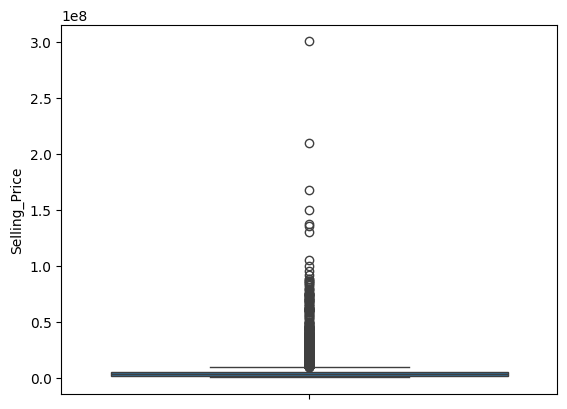

In [213]:
sns.boxplot(data['Selling_Price'])

In [214]:
sorted(data['Selling_Price'],reverse=True)

[300500000,
 210000000,
 167500000,
 150000000,
 137500000,
 135000000,
 130000000,
 105000000,
 100000000,
 95000000,
 91500000,
 88500000,
 88000000,
 86000000,
 86000000,
 85000000,
 84900000,
 84000000,
 82500000,
 81000000,
 79500000,
 79500000,
 78000000,
 76000000,
 75500000,
 75000000,
 75000000,
 75000000,
 75000000,
 73500000,
 73500000,
 72500000,
 72500000,
 72500000,
 71000000,
 70700000,
 70500000,
 70000000,
 69500000,
 69500000,
 69000000,
 68500000,
 67500000,
 67500000,
 67500000,
 66000000,
 65000000,
 65000000,
 64000000,
 62500000,
 62500000,
 62500000,
 62500000,
 61900000,
 61500000,
 61000000,
 60000000,
 60000000,
 60000000,
 60000000,
 60000000,
 59900000,
 59500000,
 59000000,
 58500000,
 57000000,
 57000000,
 56000000,
 55000000,
 54200000,
 54000000,
 52500000,
 51900000,
 50000000,
 49500000,
 49500000,
 49000000,
 48600000,
 47500000,
 47500000,
 47000000,
 46500000,
 46000000,
 46000000,
 45000000,
 45000000,
 45000000,
 45000000,
 45000000,
 45000000,
 

In [215]:
data = data[~(data['Selling_Price']>=210000000.0) & (data['Selling_Price']<=300500000.0)]

In [216]:
data.shape

(8333, 8)

In [217]:
data.head(1)

,Car_Name,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Age
0,Adam Revo 2006 1051cc,320000,320000,50000,Petrol,Customer,Manual,18


In [218]:
data['Fuel_Type'].unique()

array(['Petrol', 'Diesel', 'Hybrid', 'Electric', 'LPG'], dtype=object)

In [219]:
data['Fuel_Type'] = data['Fuel_Type'].map({'Petrol': 0, 'Diesel': 1, 'Hybrid': 2, 'Electric': 3, 'LPG': 4})

In [220]:
data['Fuel_Type'].unique()

array([0, 1, 2, 3, 4])

In [221]:
data['Seller_Type'].unique()

array(['Customer', 'PakWheels'], dtype=object)

In [222]:
data['Seller_Type'] = data['Seller_Type'].map({'Customer': 0, 'PakWheels': 1})

In [223]:
data['Seller_Type'].unique()

array([0, 1])

In [224]:
data['Transmission'].unique()

array(['Manual', 'Automatic'], dtype=object)

In [225]:
data['Transmission'] =data['Transmission'].map({'Manual':0,'Automatic':1})

In [226]:
data['Transmission'] =data['Transmission'].map({'Manual':0,'Automatic':1})

array([0, 1])

In [227]:
data.head()

,Car_Name,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Age
0,Adam Revo 2006 1051cc,320000,320000,50000,0,0,0,18
1,Adam Revo 2023,13799999,13799999,18000,1,0,1,1
2,Audi A1 1985,300000,300000,200000,0,0,0,39
3,Audi A3 2014 1.8 TFSI Quattro,6250000,6250000,67000,0,0,1,10
4,Audi A3 2014 1.8 TFSI quattro,6700000,6700000,159000,0,0,1,10


In [228]:
X = data.drop(['Car_Name','Selling_Price'],axis=1)
y = data['Selling_Price']

In [229]:
y

0         320000
1       13799999
2         300000
3        6250000
4        6700000
          ...   
8330     2500000
8331     9950000
8332     1220000
8333     1300000
8334     2700000
Name: Selling_Price, Length: 8333, dtype: int64

In [230]:
from sklearn.model_selection import train_test_split

In [231]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [232]:
#pip install xgboost

In [233]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [234]:
lr = LinearRegression()
lr.fit(X_train,y_train)

rf = RandomForestRegressor()
rf.fit(X_train,y_train)

xgb = GradientBoostingRegressor()
xgb.fit(X_train,y_train)

xg = XGBRegressor()
xg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [235]:
y_pred1 = lr.predict(X_test)
y_pred2 = rf.predict(X_test)
y_pred3 = xgb.predict(X_test)
y_pred4 = xg.predict(X_test)

In [236]:
from sklearn import metrics

In [237]:
score1 = metrics.r2_score(y_test,y_pred1)
score2 = metrics.r2_score(y_test,y_pred2)
score3 = metrics.r2_score(y_test,y_pred3)
score4 = metrics.r2_score(y_test,y_pred4)

In [238]:
print(score1,score2,score3,score4)

1.0 0.9999557129989493 0.9998852531840355 0.982822060585022


In [239]:
final_data = pd.DataFrame({'Models':['LR','RF','GBR','XG'],
             "R2_SCORE":[score1,score2,score3,score4]})

In [240]:
final_data

,Models,R2_SCORE
0,LR,1.000000
1,RF,0.999956
2,GBR,0.999885
3,XG,0.982822


<Axes: xlabel='Models', ylabel='R2_SCORE'>

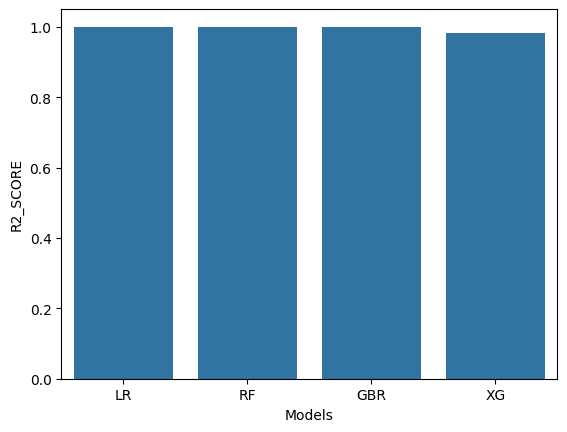

In [241]:
sns.barplot(x='Models', y='R2_SCORE', data=final_data)

In [242]:
xg = XGBRegressor()
xg_final = xg.fit(X,y)

In [243]:
import joblib

In [244]:
joblib.dump(xg_final,'car_price_predictor')

['car_price_predictor']

In [245]:
model = joblib.load('car_price_predictor')

In [253]:
import pandas as pd
data_new = pd.DataFrame({
    'Present_Price':5.59,
    'Kms_Driven':27000,
    'Fuel_Type':0,
    'Seller_Type':0,
    'Transmission':0,
    'Age':8
},index=[0])

In [254]:
prediction = model.predict(data_new)
print(prediction)

[259567.62]


# GUI

In [1]:
import pandas as pd
from tkinter import *
import joblib

def show_entry_fields():
    # Get input values from the user
    p1 = float(e1.get())  # Present_Price
    p2 = float(e2.get())  # Kms_Driven
    p3 = float(e3.get())  # Fuel_Type
    p4 = float(e4.get())  # Seller_Type
    p5 = float(e5.get())  # Transmission
    p6 = float(e6.get())  # Age
    
    # Load the pre-trained model
    model = joblib.load('car_price_predictor')
    
    # Create a DataFrame with the input values (without Owner)
    data_new = pd.DataFrame({
        'Present_Price': [p1],
        'Kms_Driven': [p2],
        'Fuel_Type': [p3],
        'Seller_Type': [p4],
        'Transmission': [p5],
        'Age': [p6]
    })
    
    # Predict the price
    result = model.predict(data_new)
    
    # Display the result
    Label(master, text="Car Purchase amount").grid(row=8)
    Label(master, text=result[0]).grid(row=10)
    print("Car Purchase amount", result[0])
    
# Set up the Tkinter window
master = Tk()
master.title("Car Price Prediction Using Machine Learning")
label = Label(master, text="Car Price Prediction Using Machine Learning", bg="black", fg="white").grid(row=0, columnspan=2)

# Create labels and entry fields for user input
Label(master, text="Present_Price").grid(row=1)
Label(master, text="Kms_Driven").grid(row=2)
Label(master, text="Fuel_Type").grid(row=3)
Label(master, text="Seller_Type").grid(row=4)
Label(master, text="Transmission").grid(row=5)
Label(master, text="Age").grid(row=6)

e1 = Entry(master)
e2 = Entry(master)
e3 = Entry(master)
e4 = Entry(master)
e5 = Entry(master)
e6 = Entry(master)

# Grid layout for input fields
e1.grid(row=1, column=1)
e2.grid(row=2, column=1)
e3.grid(row=3, column=1)
e4.grid(row=4, column=1)
e5.grid(row=5, column=1)
e6.grid(row=6, column=1)

# Add a button to trigger the prediction
Button(master, text='Predict', command=show_entry_fields).grid()

# Run the Tkinter loop
mainloop()

Car Purchase amount 211944.89
